1. Using pretrained models out of the box
2. Training models from scratch
3. Transfer Learning
4. Fine-tuning

In [2]:
import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import requests
import glob as glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

from zipfile import ZipFile
from urllib.request import urlretrieve

In [3]:
SEED_VALUE = 42

# Fix seed to make training deterministic
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

## 1 Download data and extract

In [4]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [5]:
URL = r"https://www.dropbox.com/s/uzgh5g2bnz40o13/dataset_traffic_signs_40_samples_per_class.zip?dl=1"

dataset_path   = os.path.join(os.getcwd(), "dataset_traffic_signs_40_samples_per_class")
asset_zip_path = os.path.join(os.getcwd(), "dataset_traffic_signs_40_samples_per_class.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

## 2 Dataset and Training Configuration

In [6]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 43
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
        
    DATA_ROOT_TRAIN:  str = os.path.join(dataset_path, "Train")  
    DATA_ROOT_VALID:  str = os.path.join(dataset_path, "Valid")
    DATA_ROOT_TEST:   str = os.path.join(dataset_path, "Test")
    DATA_TEST_GT:     str = os.path.join(dataset_path, "Test.csv")    
        

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 101
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int   = 8 

### 3 Create train and validation datasets

Here we use image_dataset_from_directory(), a very convenient utility in Keras for creating an image dataset. The expected file structure for a dataset is shown below, where the images for each class are contained in a separate class sub-folder.

```bash
main_directory/ 
    class_a/
        a_image_1.png
        a_image_2.png
    class_b/
        b_image_1.png
        b_image_2.png
```

In [7]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int', # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int', # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )

Found 1204 files belonging to 43 classes.
Found 516 files belonging to 43 classes.


In [8]:
print(train_dataset.class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


### Display sample images from training dataset

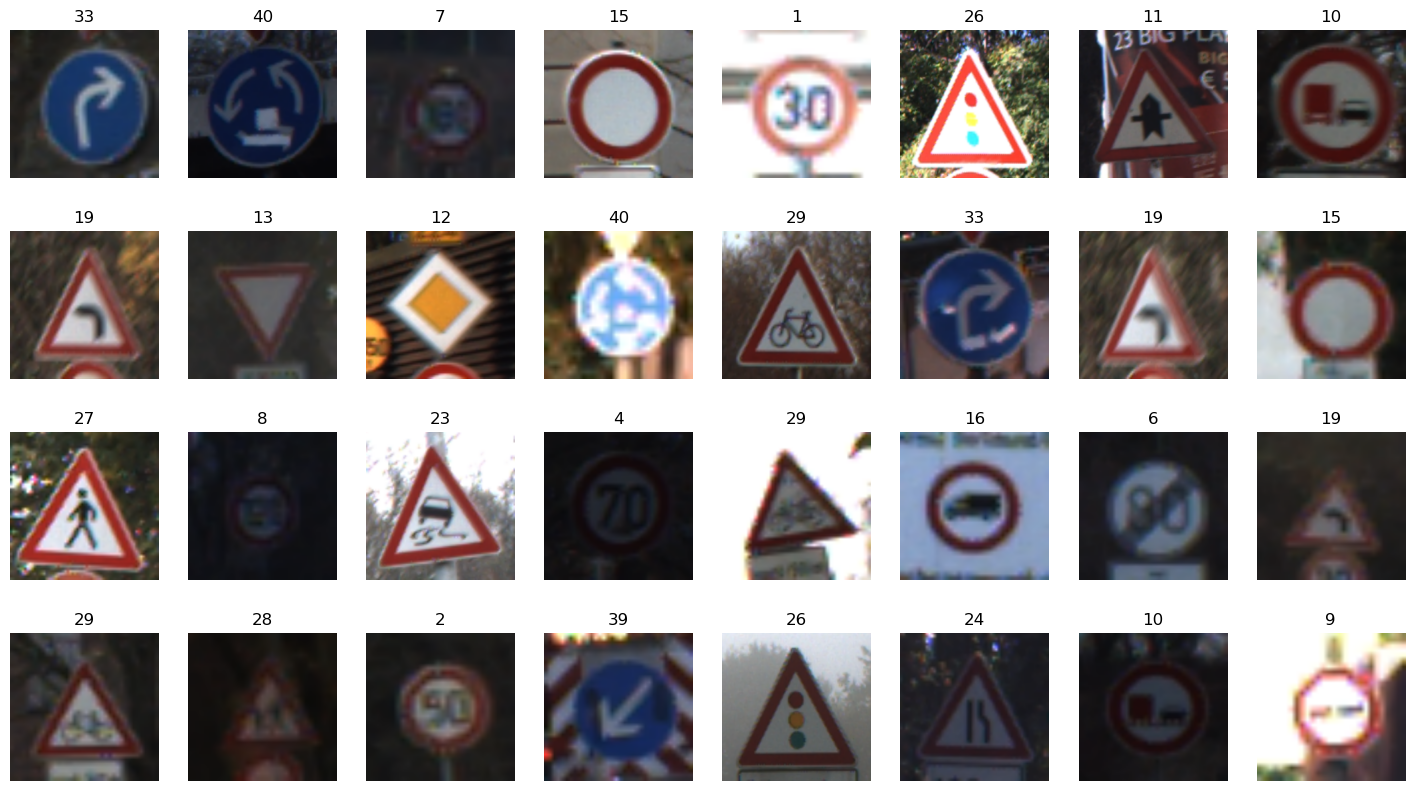

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(18,10))

num_rows = 4
num_cols = 8

# take() method retrieves just the first batch of data from training portion
for image_batch, labels_batch in train_dataset.take(1):

    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

## 4 Create test dataset

images and labels for the test dataset are stored separately on the file system -- we need custom code to read and write this data

1. retrieve the class labels from the provided csv file and store them in python list
2. build al list of image file paths in memory as a python list
3. combine the image paths and associated labels in tf.data.Dataset object
4. use the dataset object map method to load and preprocess the images in the dataset

### Load test ground truth labels from test.csv

In [10]:
import pandas as pd

input_file = DatasetConfig.DATA_TEST_GT

dataset = pd.read_csv(input_file)
df = pd.DataFrame(dataset)
cols = [6]
df = df[df.columns[cols]]
ground_truth_ids = df['ClassId'].values.tolist()
print("Total number of Test labels: ", len(ground_truth_ids))
print(ground_truth_ids[0:10])

Total number of Test labels:  12630
[16, 1, 38, 33, 11, 38, 18, 12, 25, 35]


These are in numerical order unlike our train data so we need to create a mapping

### Map ground truth class IDs to IDs in train/val dataset

In [11]:
#convert train/valid class names to integers
class_names_int = list(map(int, train_dataset.class_names))

# create a dictionary mapping ground truth IDs to class name IDs
gtid_2_cnidx = dict(zip(class_names_int, range(0, DatasetConfig.NUM_CLASSES)))

gtid_2_cnidx.items()

dict_items([(0, 0), (1, 1), (10, 2), (11, 3), (12, 4), (13, 5), (14, 6), (15, 7), (16, 8), (17, 9), (18, 10), (19, 11), (2, 12), (20, 13), (21, 14), (22, 15), (23, 16), (24, 17), (25, 18), (26, 19), (27, 20), (28, 21), (29, 22), (3, 23), (30, 24), (31, 25), (32, 26), (33, 27), (34, 28), (35, 29), (36, 30), (37, 31), (38, 32), (39, 33), (4, 34), (40, 35), (41, 36), (42, 37), (5, 38), (6, 39), (7, 40), (8, 41), (9, 42)])

In [12]:
# Convert ground truth class ids to ids that correctly map to same classes
# in traini and validation datasets
label_ids = []
for idx in range(len(ground_truth_ids)):
    label_ids.append(gtid_2_cnidx[ground_truth_ids[idx]])

print("Original ground truth class IDS: ", ground_truth_ids[0:10])
print("New Mapping required:            ", label_ids[0:10])
print("")
print("Train/Valid dataset class names: ", train_dataset.class_names)

Original ground truth class IDS:  [16, 1, 38, 33, 11, 38, 18, 12, 25, 35]
New Mapping required:             [8, 1, 32, 27, 3, 32, 10, 4, 18, 29]

Train/Valid dataset class names:  ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


### Create file paths to test images

In [13]:
# Get all path names to test images
image_paths = sorted(glob.glob(DatasetConfig.DATA_ROOT_TEST + "/*.png"))

print(len(image_paths))
print("")
# print first 5 image paths to confirm
for idx in range(5):
    print(image_paths[idx])

12630

c:\Users\Bridget Leonard\Desktop\DNN\tensorflow\dataset_traffic_signs_40_samples_per_class\Test\00000.png
c:\Users\Bridget Leonard\Desktop\DNN\tensorflow\dataset_traffic_signs_40_samples_per_class\Test\00001.png
c:\Users\Bridget Leonard\Desktop\DNN\tensorflow\dataset_traffic_signs_40_samples_per_class\Test\00002.png
c:\Users\Bridget Leonard\Desktop\DNN\tensorflow\dataset_traffic_signs_40_samples_per_class\Test\00003.png
c:\Users\Bridget Leonard\Desktop\DNN\tensorflow\dataset_traffic_signs_40_samples_per_class\Test\00004.png


### Combine images and labels to create Test dataset
Use from_tensor_slices() to combine image paths and labels in a tf.data.dataset

In [14]:
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_ids))

### Load and preprocess images

In [15]:
def preprocess_image(image):
    # Decode and resize image
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH])
    return image

In [16]:
def load_and_preprocess_image(path):
    # Read image into memory as a byte string
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [17]:
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

Now load and preprocess images using test dataset's map() method and call functions above. Also set batch size of dataset

In [18]:
# Apply functions to test dataset

test_dataset = test_dataset.map(load_and_preprocess_from_path_label)
# returns dataset with preprocessed images and their ground truth labels

# Set batch size for dataset
test_dataset = test_dataset.batch(TrainingConfig.BATCH_SIZE)

### Display sample images from test dataset

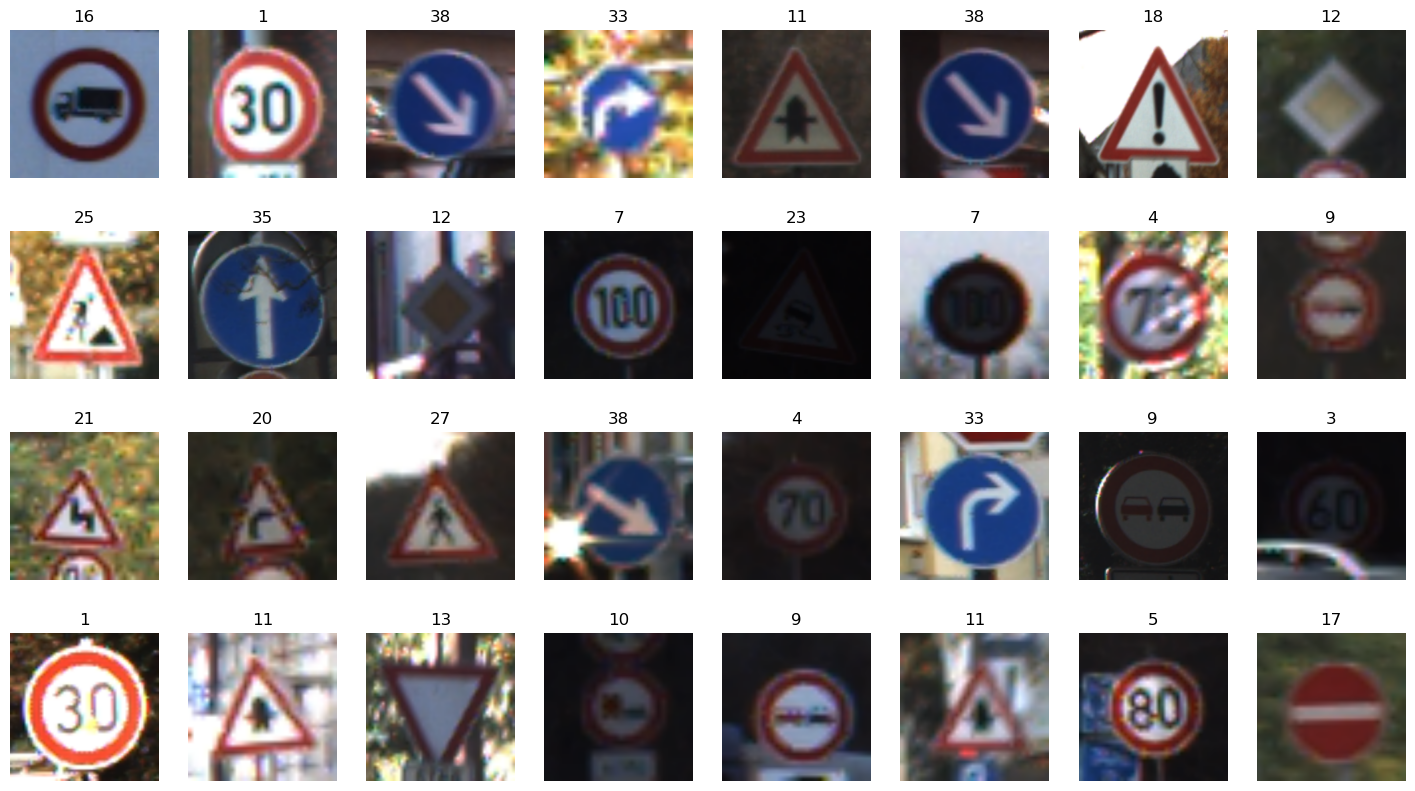

In [19]:
plt.figure(figsize=(18,10))

num_rows= 4
num_cols= 8

for image_batch, labels_batch in test_dataset.take(1):
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

## 6 Modeling VGG-16

In [20]:
tf.keras.applications.vgg16.VGG16(include_top=True,
                                  weights='imagenet',
                                  input_tensor=None,
                                  input_shape=None,
                                  pooling=None,
                                  classes=1000,
                                  classifier_activation='softmax')

To configure the model for Fine-Tuning, we will load the model's convolutional base with weights that were learned from the ImageNet dataset. These weights serve as a starting point for Fine-Tuning the model for our dataset. Since we need to redefine the classifier, we will load the model without a classifier (`include_top=False`), so we can specify our own classifier for the dataset.

### Loading VGG-16 Convolutional Base

In [21]:
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)

print("Loading model with ImageNet weights...")
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, # we will supply our own top
                                                    weights='imagenet')
print(vgg16_conv_base.summary())

Loading model with ImageNet weights...
58889256/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                       

### Freeze initial layers in the convolutional base
We need to lock down the initial layers so that only the last few (TrainingConfig.LAYERS_FINE_TUNE = 8) are trainable. There are two ways to do this.
    1. Start by making the entire convolutionall base trainable by setting the trainable flag to True. Then loop over the initial layers and make them untrainable by setting the same trainable flag for each layer to False
    2. Freeze the entire convolutional base by setting the t rainable flag to False, then loop over last few layers to set the trainable flag to true

We'll use the first approach.

In [22]:
# Seat all layers in conv base to Trainable (will freeze initial layers below)
vgg16_conv_base.trainable = True

# Speicify number of layers to fine tune at the end of convolution base
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(vgg16_conv_base.layers)

# Freeze initial layers
for model_layer in vgg16_conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYERS; {model_layer}")
    model_layer.trainable = False

print("\n")
print(f"Configured to fine tune the last", num_layers_fine_tune, "convolutional layers...")
print("\n")

print(vgg16_conv_base.summary())

FREEZING LAYERS; <keras.src.engine.input_layer.InputLayer object at 0x0000020F83240070>
FREEZING LAYERS; <keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000020F80F87F40>
FREEZING LAYERS; <keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000020F80F87220>
FREEZING LAYERS; <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000020F80F92130>
FREEZING LAYERS; <keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000020F80F920D0>
FREEZING LAYERS; <keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000020F80F62340>
FREEZING LAYERS; <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000020F80DAA4C0>
FREEZING LAYERS; <keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000020F80DAA3D0>
FREEZING LAYERS; <keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000020F80ED4100>
FREEZING LAYERS; <keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000020F80F976D0>
FREEZING LAYERS; <keras.src.layers.pooling.max_pooling2d.MaxP

We see the number of trainable parameters has decreased since we froze certain laers

### Add the classifier to complete the model

In [24]:
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.applications.vgg16.preprocess_input(inputs)

x = vgg16_conv_base(x)

# Flatten the output from the convolutional base
x = layers.Flatten()(x)

# Add the classifer
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(TrainingConfig.DROPOUT)(x)

# Output layer
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)

# Final model
model_vgg16_finetune = keras.Model(inputs, outputs)

print(model_vgg16_finetune.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               321139

### Compile and train model

We are using SparseCategoricalCrossentropy since we are using integer-encoded labels. Since we included a softmax layer in the model output, we specifiy from_logits=False. This is default but good practice to be explicity. Alternatively you can remove the softmax layer and set from_logits=True and the loss funciton will apply the softmax function internally. The results should be identical 

In [25]:
model_vgg16_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=["accuracy"]
                             )

In [26]:
training_results = model_vgg16_finetune.fit(train_dataset,
                                            epochs=TrainingConfig.EPOCHS,
                                            validation_data=valid_dataset)

Epoch 1/101
38/38 [==============================] - 313s 8s/step - loss: 4.6394 - accuracy: 0.0257 - val_loss: 3.7498 - val_accuracy: 0.0329
Epoch 2/101
38/38 [==============================] - 329s 9s/step - loss: 3.7576 - accuracy: 0.0241 - val_loss: 3.7491 - val_accuracy: 0.0407
Epoch 3/101
38/38 [==============================] - 312s 8s/step - loss: 3.7371 - accuracy: 0.0224 - val_loss: 3.7239 - val_accuracy: 0.0329
Epoch 4/101
38/38 [==============================] - 315s 8s/step - loss: 3.6884 - accuracy: 0.0390 - val_loss: 3.5116 - val_accuracy: 0.0988
Epoch 5/101
38/38 [==============================] - 316s 8s/step - loss: 3.3873 - accuracy: 0.1055 - val_loss: 3.0747 - val_accuracy: 0.1977
Epoch 6/101
38/38 [==============================] - 330s 9s/step - loss: 2.9830 - accuracy: 0.1885 - val_loss: 2.4304 - val_accuracy: 0.3566
Epoch 7/101
38/38 [==============================] - 322s 8s/step - loss: 2.5229 - accuracy: 0.2807 - val_loss: 2.3052 - val_accuracy: 0.4380
Epoch 

## Plot results

In [27]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS - 1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

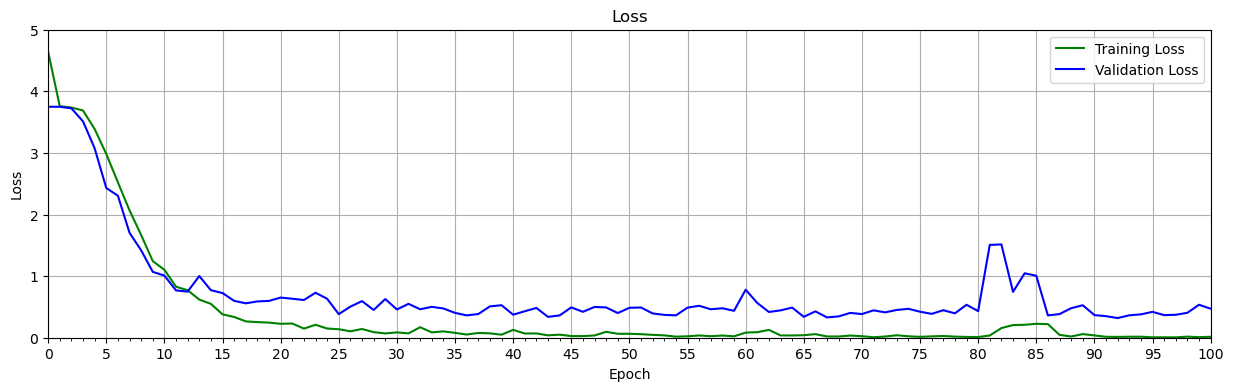

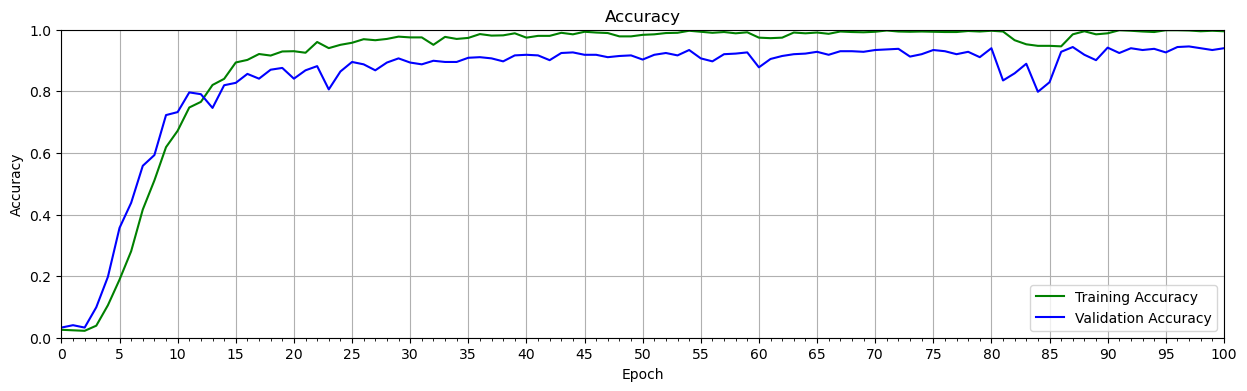

In [28]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 5.0],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

plot_results(
    [train_acc, valid_acc],
    ylabel="Accuracy",
    ylim=[0.0, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

## Model Evaluation

### Validation dataset

In [29]:
print(f"Model valid accuracy: {model_vgg16_finetune.evaluate(valid_dataset)[1]*100.:.3f}")

17/17 [==============================] - 47s 3s/step - loss: 0.4714 - accuracy: 0.9399
Model valid accuracy: 93.992


### Test Dataset

In [31]:
print(f"Model test accuracy: {model_vgg16_finetune.evaluate(test_dataset)[1]*100.:.3f}")

395/395 [==============================] - 1457s 4s/step - loss: 0.3849 - accuracy: 0.9374
Model test accuracy: 93.737


### Display sample predictions

In [32]:
def display_predictions(dataset, model, class_names):
    
    plt.figure(figsize=(20, 20))
    num_rows = 8
    num_cols = 8
    jdx = 0

    # Evaluate two batches.
    for image_batch, labels_batch in dataset.take(2):
        print(image_batch.shape)

        # Predictions for the current batch.
        predictions = model.predict(image_batch)

        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = labels_batch[idx].numpy()

            # Set the title color based on the prediction.
            if pred_idx == truth_idx:
                color = "g"
            else:
                color = "r"

            jdx += 1

            if jdx > num_rows * num_cols:
                # Break from the loops if the maximum number of images have been plotted
                break

            ax = plt.subplot(num_rows, num_cols, jdx)
            title = str(class_names[truth_idx]) + " : " + str(class_names[pred_idx])

            title_obj = plt.title(title)
            plt.setp(title_obj, color=color)
            plt.axis("off")
            plt.imshow(image_batch[idx].numpy().astype("uint8"))
    return

(32, 224, 224, 3)
1/1 [==============================] - 2s 2s/step
(32, 224, 224, 3)
1/1 [==============================] - 2s 2s/step


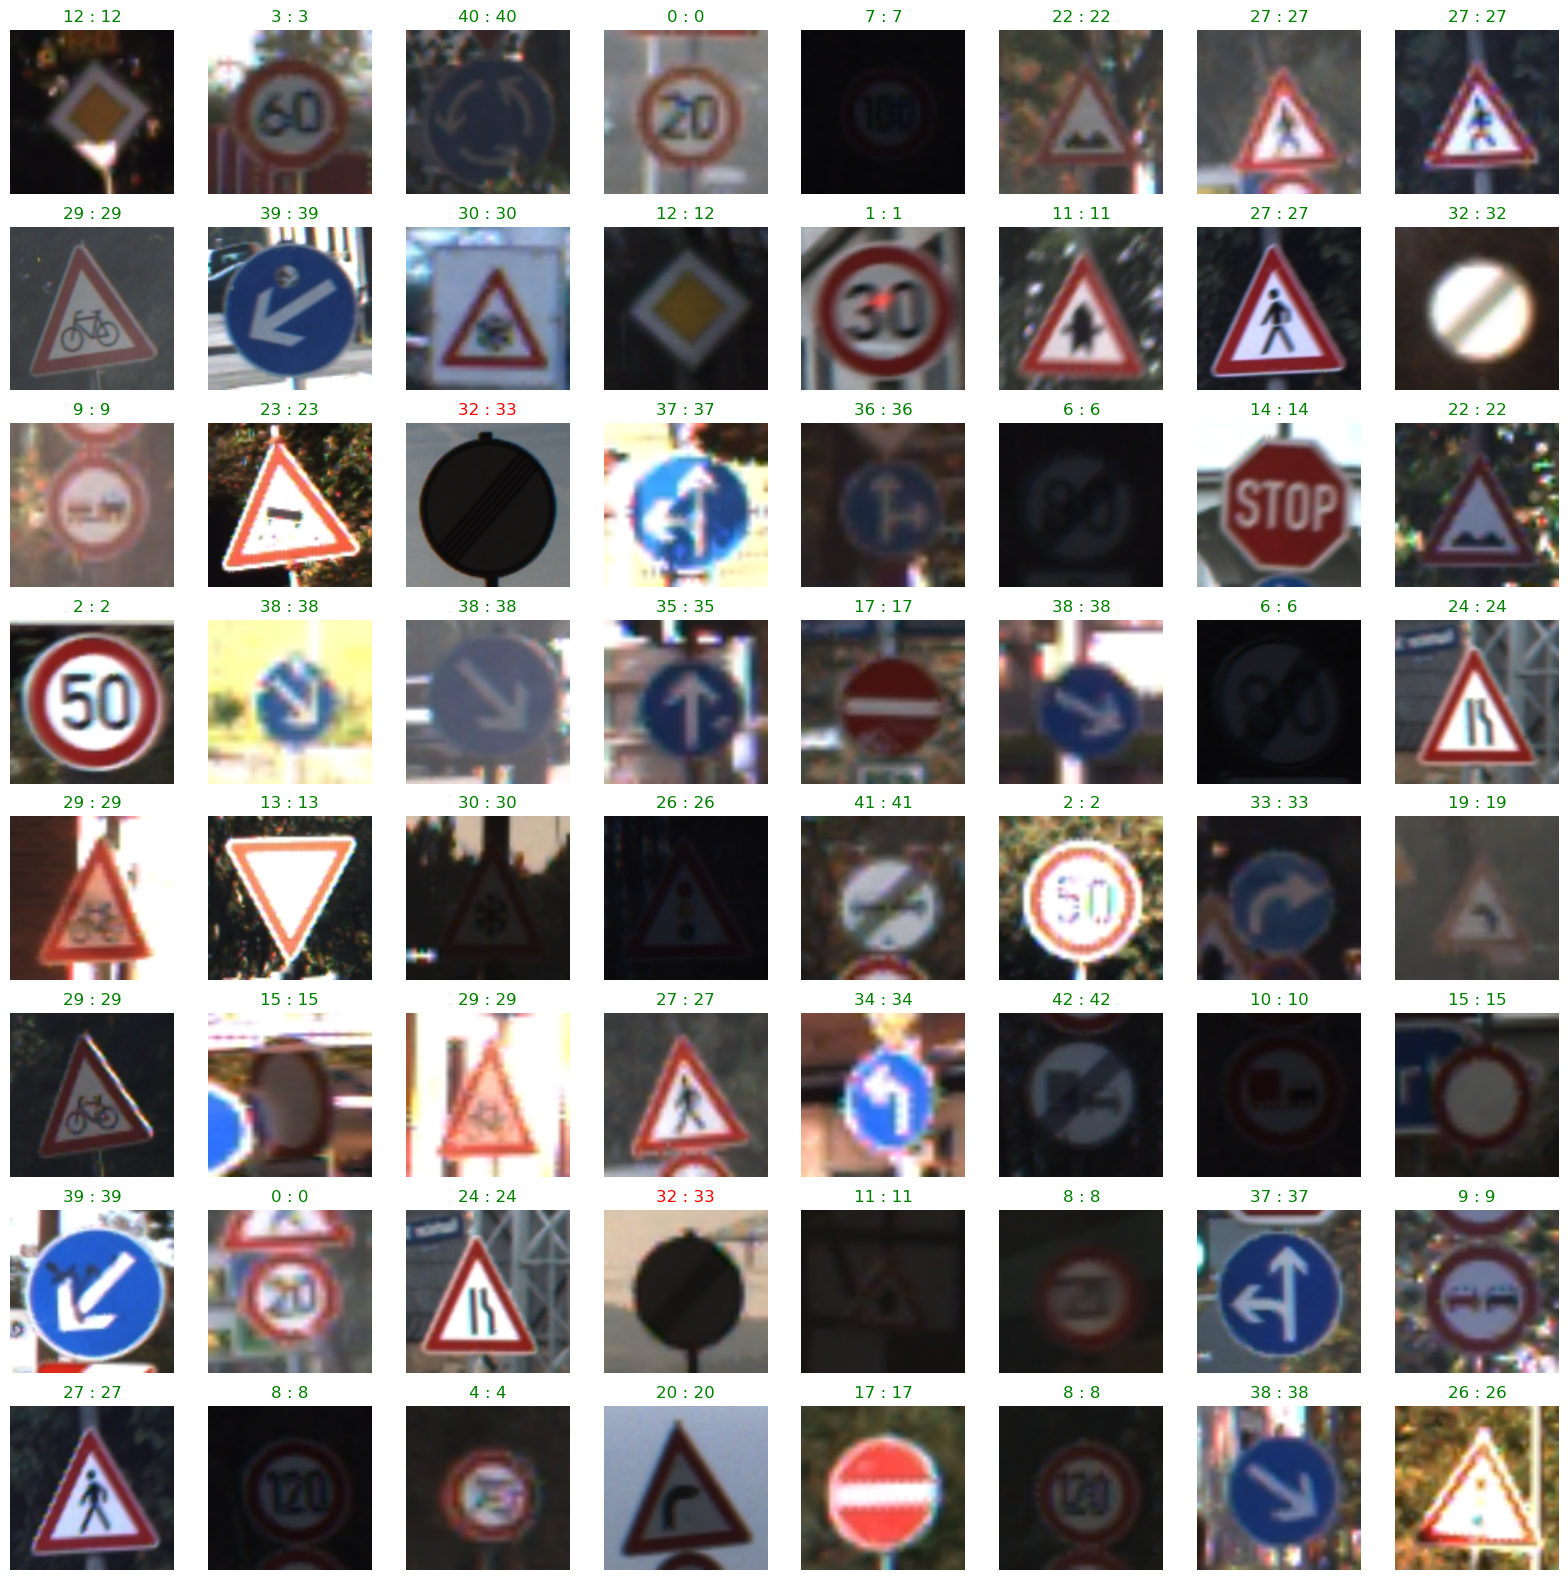

In [33]:
# Sample validation
display_predictions(valid_dataset, model_vgg16_finetune, class_names)

(32, 224, 224, 3)
1/1 [==============================] - 2s 2s/step
(32, 224, 224, 3)
1/1 [==============================] - 2s 2s/step


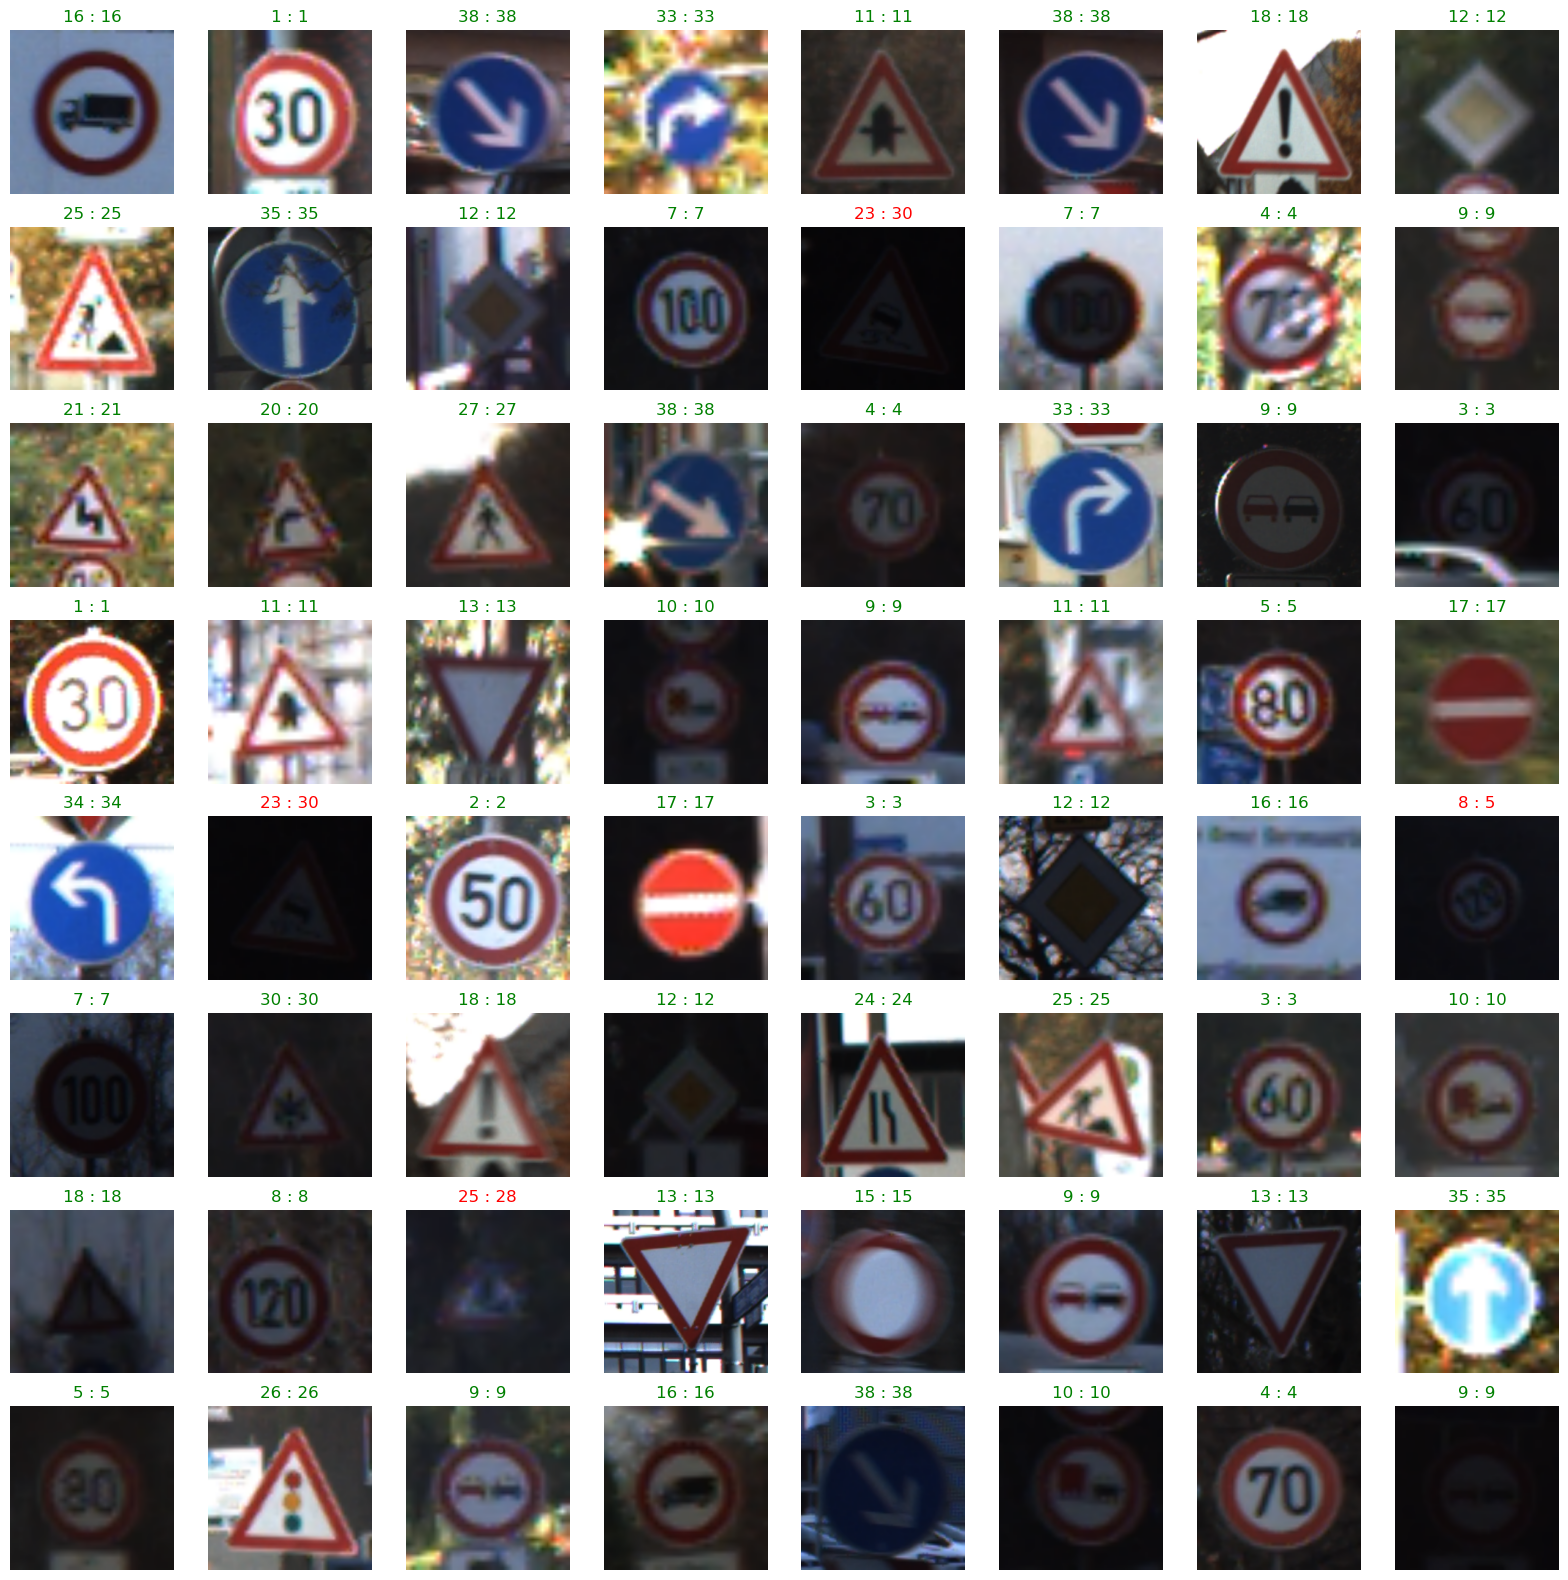

In [34]:
# Sample test
display_predictions(test_dataset, model_vgg16_finetune, class_names)